In [1]:
# read in libraries
import sys, os
import netCDF4
import scipy.io, numpy
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

56 60
newdf       dry_dia       time        date        N_tot      kappa       conc  \
0        50.0  18.145556  20210427.0  4971.089985  -0.112996  52.590000   
1        50.0  18.145556  20210427.0  4971.089985  -0.102498  56.419998   
2        50.0  18.145556  20210427.0  4971.089985  -0.091346  26.540001   
3        50.0  18.145556  20210427.0  4971.089985  -0.079495   9.420000   
4        50.0  18.145556  20210427.0  4971.089985  -0.067010  14.130000   
...       ...        ...         ...          ...        ...        ...   
3355     50.0  23.935833  20210427.0  4785.360053   7.907920   0.000000   
3356     50.0  23.935833  20210427.0  4785.360053   8.647406   0.000000   
3357     50.0  23.935833  20210427.0  4785.360053   9.460975   0.000000   
3358     50.0  23.935833  20210427.0  4785.360053  10.355241   0.000000   
3359     50.0  23.935833  20210427.0  4785.360053  11.340759   0.000000   

            dK   conc_norm0  conc_norm  p_MH_i  p_LH_i  H_i  H_alpha_i  \
0     0.01023

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


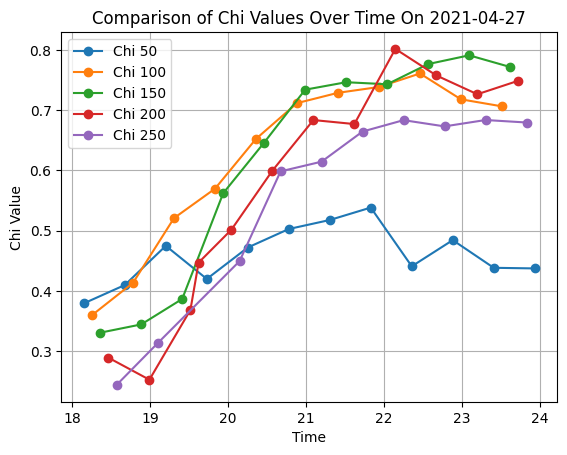

In [81]:
directory = '/Users/evenhou/Downloads/armdata'
# kappa_50 = pd.Series() # array, for all kappa in all file with size = 50 nm
# conc_norm1_50 = pd.Series() # array, for all normalized conc in all file with size = 50 nm
# #volume fraction at bin i
# p_LH_i = pd.Series()
# p_MH_i = pd.Series()
kappa_LH = 0.01
kappa_MH = 0.65
day =  np.array([])
k50 = np.array([]) 

chi50 = np.array([]) 
chi100 = np.array([])
chi150 = np.array([])
chi200 = np.array([])
chi250 = np.array([])

conc50 = np.array([]) 

for subdir, dirs, files in os.walk(directory):
    for file in files:
        filename = subdir + os.sep + file
        if ('sgpaoshtdmaE13.b1.20210427' in filename) and ('.nc' in filename):
# =============== FOR EACH FILE ===============
# get dimensions of time and bins
            ds = netCDF4.Dataset(filename)
            s1 = str(ds.dimensions['time'])
            s2 = str(ds.dimensions['bin'])
            # print(s)
            x = -3
            if (s1[x-1:x+1] != '='):
                dim_time = int(s1[x:])
            else:
                dim_time = int(s1[x-1:])
            if (s2[x-1:x+1] != '='):
                dim_bin = int(s2[x:])
            else:
                dim_bin = int(s2[x-1:])
            print(dim_time, dim_bin)
            
# CHANGE HERE: define arrays
            time = np.zeros(dim_time)
            dry_dia = np.zeros(dim_time)
            kappa = np.zeros((dim_time, dim_bin))
            k_bound = np.zeros((dim_time, dim_bin,2))
            conc = np.zeros((dim_time, dim_bin))
            # date = np.zeros(dim_time)
            
# CHANGE HERE: read data into arrays
            ncf = scipy.io.netcdf_file(filename, mmap=False)
            date = int(filename[-18:-10]) # read i.e. 20210427
            #print(date0)
            #print(i_file)
            # print(type(date))
            # day = np.append(day,np.repeat(date,dim_time))
            # timestamps_series = pd.Series(day)
            # dates = pd.to_datetime(timestamps_series, unit='s')
            # print(dates)
            # print(day,type(day))
            time[:] = ncf.variables["time"].data/3600 # hr
            dry_dia[:] = ncf.variables["dry_diameter_setting"].data # nm
            for i_time in range(dim_time):
                kappa[i_time, :] = ncf.variables['kappa'][i_time, :]
                k_bound[i_time, :, :] = ncf.variables['kappa_bounds'][i_time, :, :]
                conc[i_time,:] = ncf.variables['aerosol_concentration'][i_time, :] # dN, unit: 1/cm^3
            # print(dry_dia)
            # print(k_bound)

# calculations
            dK = np.zeros((dim_time,dim_bin))
            for i_time in range(dim_time):
                dK[i_time, :] = k_bound[i_time, :, 1] -  k_bound[i_time, :, 0]
            conc_norm0 = np.zeros((dim_time,dim_bin)) # dN/dK
            for i_time in range(dim_time):
                conc_norm0[i_time, :] = conc[i_time, :]/dK[i_time, :]
            
# use pandas to manipulate data
            d = {'dry_dia': dry_dia, 'time':time, 'date':date}
            df = pd.DataFrame(data = d)
            #print(df)
    
            df_conc = pd.DataFrame(conc)
            # print(df_conc)
            N_tot = df_conc.sum(axis=1)# N_tot (series) for each scan
            N_tot.name = "N_tot"
            #print(N_tot) 
            #print(type(N_tot)) # Series
            
            df = df.join(N_tot)
            # print(df)
            Ntot = N_tot.to_numpy()
            conc_norm = np.zeros((dim_time,dim_bin))
            for i_time in range(dim_time):
                conc_norm[i_time, :] = conc_norm0[i_time, :]/Ntot[i_time]
            # print(conc_norm)
            
            newdf = pd.DataFrame(np.repeat(df.values, dim_bin, axis=0),
                                 columns=df.columns)
            # print(dim_bin)
            #print(newdf.shape)
            newdf['kappa'] = kappa.ravel() # K_i
            newdf['conc'] = conc.ravel()
            newdf['dK'] = dK.ravel()
            newdf['conc_norm0'] = conc_norm0.ravel()  # dN/dK

            # print(newdf.head(60))
            
            # print(newdf.describe(include = 'all'))
            # has_zero = (newdf['N_tot'] == 0).any()
            # print(has_zero)
            # row_indices = newdf.index[newdf['N_tot'] == 0].tolist()
            # print(row_indices)

            # newdf_1 = newdf[(newdf['N_tot'] != 0)]
            # # print(newdf_1.iloc[6180:6779])
            # print(newdf_1)
            # has_zero1 = (newdf_1['N_tot'] == 0).any()
            # print(has_zero1)
            # print(newdf_1.isna().any().any())
            
            newdf['conc_norm'] = newdf['conc_norm0']/newdf['N_tot'] # dN°/dK = c(k)_i
            newdf['p_MH_i'] = (newdf.kappa-kappa_LH)/(kappa_MH-kappa_LH)
            newdf['p_LH_i'] = 1 - newdf['p_MH_i']
            
            newdf.loc[newdf['N_tot'] == 0, 'p_MH_i'] = 0
            newdf.loc[newdf['kappa'] < kappa_LH, 'p_MH_i'] = 0
            newdf.loc[newdf['kappa'] > kappa_MH, 'p_MH_i'] = 0

            newdf.loc[newdf['N_tot'] == 0, 'p_LH_i'] = 0
            newdf.loc[newdf['kappa'] < kappa_LH, 'p_LH_i'] = 0
            newdf.loc[newdf['kappa'] > kappa_MH, 'p_LH_i'] = 0
            
            newdf['H_i'] = -newdf.p_LH_i*np.log(newdf.p_LH_i)-newdf.p_MH_i*np.log(newdf.p_MH_i)
            newdf['H_alpha_i'] = newdf.H_i*newdf.conc_norm*newdf.dK
            newdf['p_mh_i'] = newdf.p_MH_i*newdf.conc_norm*newdf.dK
            newdf['p_lh_i'] = newdf.p_LH_i*newdf.conc_norm*newdf.dK
            
            newdf.loc[newdf['N_tot'] == 0, 'H_alpha_i'] = 0
            newdf.loc[newdf['kappa'] < kappa_LH, 'H_alpha_i'] = 0
            newdf.loc[newdf['kappa'] > kappa_MH, 'H_alpha_i'] = 0
            
            print("newdf",newdf)
            
            H_alpha = np.array([])
            p_MH = np.array([])
            p_LH = np.array([])
            for i in range(0,int(len(newdf)/60)):
                h_alpha = (newdf.iloc[i*60:i*60+59].sum()).H_alpha_i
                H_alpha = np.append(H_alpha,h_alpha)
                p_mh = (newdf.iloc[i*60:i*60+59].sum()).p_mh_i
                p_lh = (newdf.iloc[i*60:i*60+59].sum()).p_lh_i
                p_MH = np.append(p_MH,p_mh)
                p_LH = np.append(p_LH,p_lh)
            # print(len(H_alpha))
            # print("H_alpha",H_alpha)
            # print(len(p_MH))
            # print(p_LH.max())
            # print(p_LH.min())
            # print(newdf.describe(include = 'all'))

            D_alpha = np.exp(H_alpha)
            # print(D_alpha)
            H_gamma = -p_LH*np.log(p_LH)-p_MH*np.log(p_MH)
            # print("H_gamma",H_gamma)

            H_gamma = np.nan_to_num(H_gamma)
            # print("H_gamma",H_gamma)
            
            D_gamma = np.exp(H_gamma)
            chi = (D_alpha-1)/(D_gamma-1)
            # print("chi",chi)
            # print(len(chi))

            df['p_MH'] = p_MH.tolist()
            df['p_LH'] = p_LH.tolist()
            df['D_alpha'] = D_alpha.tolist()
            df['D_gamma'] = D_gamma.tolist()
            df['chi'] = chi.tolist()
            # plt.scatter(time,p_LH)
            # print(df)

            df_valid = df[df['N_tot'] != 0]
            # print(df_valid.chi)
            df_valid = df.dropna(subset=["chi"])
            # print(df_valid.chi)
            # print(df_valid)
            chi_final = df_valid["chi"].to_numpy()
            
            df50 = df_valid[df_valid["dry_dia"] == 50]
            df100 = df_valid[df_valid["dry_dia"] == 100]
            df150 = df_valid[df_valid["dry_dia"] == 150]
            df200 = df_valid[df_valid["dry_dia"] == 200]
            df250 = df_valid[df_valid["dry_dia"] == 250]

            # print(df50)
            # print(df100)
            time50_i = df50["time"].to_numpy()
            chi50_i = df50["chi"].to_numpy()
            chi50 = np.append(chi50,chi50_i)
            # print("chi50",chi50)
            # print(len(chi50))
            # print("len of chi50",len(chi50))

            chi100_i = df100["chi"].to_numpy()
            chi100 = np.append(chi100,chi100_i)
            # print("chi100",chi100)8210
            # print("len of chi100",len(chi100))
            chi150_i = df150["chi"].to_numpy()
            chi150 = np.append(chi150,chi150_i)
            
            chi200_i = df200["chi"].to_numpy()
            chi200 = np.append(chi200,chi200_i)
            
            chi250_i = df250["chi"].to_numpy()
            chi250 = np.append(chi250,chi250_i)

plt.plot(df50.time, chi50, label='Chi 50', marker='o')
plt.plot(df100.time, chi100, label='Chi 100', marker='o')
plt.plot(df150.time, chi150, label='Chi 150', marker='o')
plt.plot(df200.time, chi200, label='Chi 200', marker='o')
plt.plot(df250.time, chi250, label='Chi 250', marker='o')
date_str = f"{date:8}"  # Convert to string for formatting
formatted_date = f"{date_str[0:4]}-{date_str[4:6]}-{date_str[6:8]}"  # YYYY-MM-DD
plt.title(f'Comparison of Chi Values Over Time On {formatted_date}')
plt.xlabel('Time')
plt.xlabel('Time')
plt.ylabel('Chi Value')
plt.legend()
plt.grid(True)
plt.show()
# plt.plot(time50_i,chi50)

In [43]:
print(dK)

[[ 0.18367481  0.19715869  0.21154654 ... 22.32444763 24.69018555
  27.27874756]
 [ 0.19509053  0.20911264  0.22560811 ... 24.56336975 27.12786865
  29.94674683]
 [ 0.20084429  0.21571898  0.23219633 ... 25.38848877 27.96191406
  30.80551147]
 ...
 [ 0.19145155  0.20526314  0.21997213 ... 17.55513    19.18034363
  20.9559021 ]
 [ 0.24983954  0.26918554  0.28994274 ... 27.23635864 29.95776367
  33.03442383]
 [ 0.20296693  0.21673751  0.23373103 ... 24.70458984 27.27612305
  30.18539429]]


In [53]:
kappa[1,:]

array([-9.72476676e-02, -8.88923332e-02, -8.00429657e-02, -7.05738664e-02,
       -6.04419224e-02, -4.96524349e-02, -3.81093696e-02, -2.57612504e-02,
       -1.25533780e-02,  1.57202908e-03,  1.68024506e-02,  3.30872796e-02,
        5.06334454e-02,  6.94602802e-02,  8.96552578e-02,  1.11468501e-01,
        1.34855002e-01,  1.60178140e-01,  1.87404037e-01,  2.16758460e-01,
        2.48493060e-01,  2.82679588e-01,  3.19709003e-01,  3.59681010e-01,
        4.03048754e-01,  4.49820250e-01,  5.00634074e-01,  5.55666327e-01,
        6.15378976e-01,  6.80130959e-01,  7.50304222e-01,  8.26818705e-01,
        9.09828722e-01,  1.00001824e+00,  1.09834242e+00,  1.20524800e+00,
        1.32184911e+00,  1.44916677e+00,  1.58783531e+00,  1.73927915e+00,
        1.90455151e+00,  2.08535957e+00,  2.28300905e+00,  2.49922442e+00,
        2.73624992e+00,  2.99550796e+00,  3.28001213e+00,  3.59236217e+00,
        3.93498969e+00,  4.31096506e+00,  4.72463751e+00,  5.17937088e+00,
        5.67989159e+00,  

In [112]:
from scipy import interpolate

xnew = np.linspace(0, 1.3, 30) # K0
dNdK = np.zeros((dim_time,30))

for i_time in range(dim_time):
# i_time = 1
    # dia = dry_dia[i_time]
    x = kappa[i_time,:] # one scan:kappa
    y = conc_norm[i_time,:] # one scan: c(k)
    f = interpolate.interp1d(x,y,fill_value="extrapolate")
    ynew = f(xnew)
    dNdK[i_time,:] = ynew
    # Calculate the average y values for each x bin

dia = np.repeat(dry_dia, 30) # for one scan
x_flat = np.tile(xnew, dim_time) # for different bin
# print(x_flat)
y_flat = dNdK.ravel()
# print(y_flat.shape)

d1 = {'dia': dia, 'K0':x_flat, 'dNdK':y_flat}
df_k = pd.DataFrame(data = d1)
# print(df_k.head(60))

df_k100 = df_k[df_k["dia"] == 100]
print(df_k100)

# plt.plot(x, y, 'o', xnew, ynew, 'o')
# plt.title('for 1 scan')
# plt.xlabel('Kappa')
# plt.ylabel('dN/dK')
# plt.show()
dNdK100 = df_k100['dNdK'].to_numpy()
d_scan = int(df_k100.shape[0]/30)
# print(d_scan)
dNdK100_matrix = dNdK100.reshape(d_scan, 30)
# print(dNdK_matrix)
# print(dNdK100_matrix.shape)
avg = np.mean(dNdK100_matrix, axis=0)
# print(len(avg))

        dia        K0      dNdK
30    100.0  0.000000  1.320052
31    100.0  0.044828  0.680044
32    100.0  0.089655  0.380442
33    100.0  0.134483  0.185554
34    100.0  0.179310  0.301541
...     ...       ...       ...
1555  100.0  1.120690  0.000000
1556  100.0  1.165517  0.000000
1557  100.0  1.210345  0.000000
1558  100.0  1.255172  0.000000
1559  100.0  1.300000  0.000000

[330 rows x 3 columns]


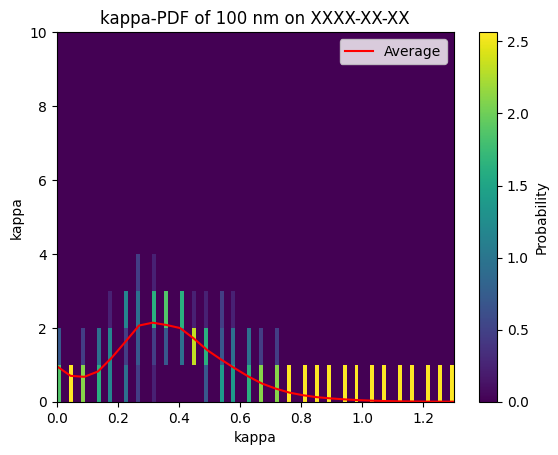

In [116]:
fig, ax = plt.subplots()
h, xedges, yedges, image = ax.hist2d(df_k100.K0, df_k100.dNdK, bins=(100, 10), range=[[0, 1.3], [0, 10]], cmap='viridis', density=True)

# Plot the average line
ax.plot(xnew, avg, color='red', label='Average')

# Adding the colorbar
cbar = plt.colorbar(image, ax=ax)
cbar.set_label('Probability')  # Label the colorbar
# Customizing the plot
ax.set_xlabel('kappa')
ax.set_ylabel('kappa')
ax.set_title('kappa-PDF of 100 nm on XXXX-XX-XX')
ax.legend()

# Display the plot
plt.show()

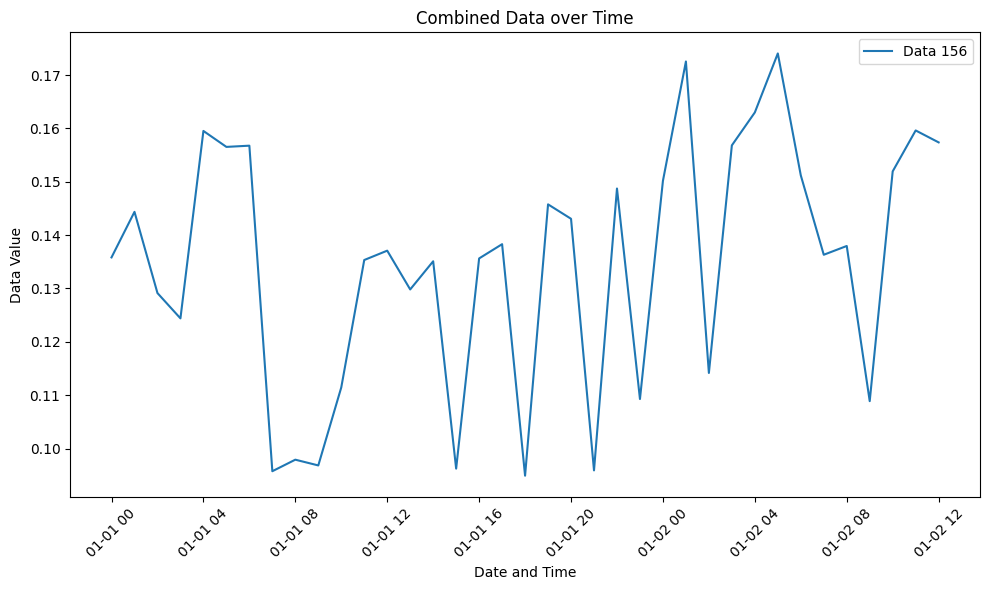

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Sample data: 24 hourly measurements for two variables
time_hours = np.arange(np.shape(chi50)[0])  # 0 to 23 hours

# Combine the data arrays
data_combined = chi50

# Create a date range. For this example, starting from January 1, 2023.
start_date = '2021-10-11'
date_range = pd.date_range(start=start_date, periods=len(time_hours), freq='H')

# Plotting
plt.figure(figsize=(10, 6))
# for i in range(data_combined.shape[1]):
plt.plot(date_range, data_combined, label=f'Data {i+1}')

plt.xlabel('Date and Time')
plt.ylabel('Data Value')
plt.title('Combined Data over Time')
plt.legend()
plt.xticks(rotation=45)  # Rotate date labels for better readability
plt.tight_layout()
plt.show()


In [76]:
def findChi(newdf,size):
    newdf_valid = newdf[(newdf['kappa'] >= kappa_LH) & (newdf['kappa'] <= kappa_MH) & (newdf['N_tot'] != 0)]
    if size == 50:
        df = newdf_valid[newdf_valid['dry_dia']==50]
    elif size == 100:
        df = newdf_valid[newdf_valid['dry_dia']==100]
    elif size == 150:
        df = newdf_valid[newdf_valid['dry_dia']==150]
    elif size == 200:
        df = newdf_valid[newdf_valid['dry_dia']==200]
    elif size == 250:
        df = newdf_valid[newdf_valid['dry_dia']==250]

    kappa = df["kappa"].to_numpy()
    conc_norm0 = df50["conc_norm0"].to_numpy() # dN/dK
    conc_norm = df["conc_norm"].to_numpy() # c(k)
    p_MH_i = df["p_MH_i"].to_numpy()
    p_LH_i = df["p_LH_i"].to_numpy()
    dK = df["dK"].to_numpy()

    H_i = -p_LH_i*np.log(p_LH_i)-p_MH_i*np.log(p_MH_i)
    H_alpha_i = H_i*conc_norm*dK
    # H_alpha_i = numpy.nan_to_num(H_alpha_i, copy=True, nan=0.0, posinf=None, neginf=None)

    H_alpha = np.sum(H_alpha_i)
    D_alpha = np.exp(H_alpha)
    p_MH = np.sum(p_MH_i*conc_norm*dK)
    p_LH = np.sum(p_LH_i*conc_norm*dK)
    H_gamma = -p_LH*np.log(p_LH)-p_MH*np.log(p_MH)
    D_gamma = np.exp(H_gamma)
    chi = (D_alpha-1)/(D_gamma-1)
    print("Chi for size ", size,":",chi)
    # has_nan = np.isnan(conc_norm).any()
    return chi

       chi_k  D_gamma_k  D_alpha_k  kappa_avg_k     time_k
0   0.476124   2.060776   1.505061     0.276018   0.426944
1   0.246365   1.935237   1.230410     0.277707   0.953333
2   0.206872   1.736506   1.152362     0.268533   1.479722
3   0.202500   1.761518   1.154208     0.261736   2.006111
4   0.288741   1.878813   1.253749     0.276238   2.532500
5   0.472295   2.051916   1.496815     0.272360   3.058889
6   0.627743   1.867064   1.544294     0.276935   3.585278
7   0.502053   1.790505   1.396875     0.276283   4.111667
8   0.584791   1.993667   1.581088     0.263632   4.638056
9   0.625990   1.947348   1.593030     0.276151   5.164444
10  0.484171   2.000586   1.484455     0.258514   5.690833
11  0.393040   1.993303   1.390408     0.274678   6.217222
12  0.294889   1.824219   1.243053     0.273912   6.743611
13  0.489469   1.706968   1.346039     0.262977   7.270000
14  0.539244   1.886484   1.478031     0.275647   7.796389
15  0.531518   1.981449   1.521658     0.263784   8.3227

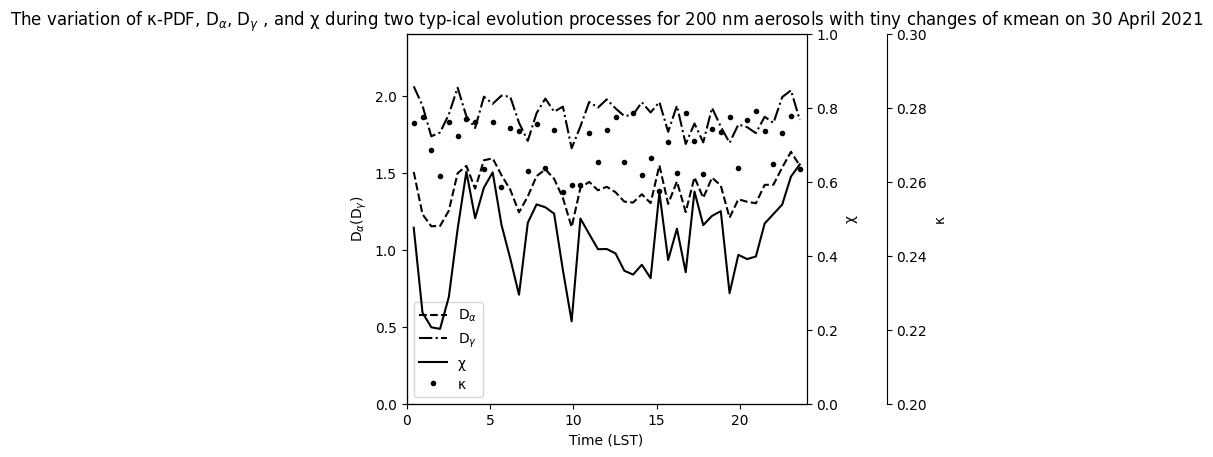

In [4]:
            # hygroscopic heterogeneity parameter
            chi_k = (D_alpha_k-1)/(D_gamma_k-1)
            #print(chi)
            
            # change array to pd series
            D_alpha_k = pd.Series(D_alpha_k)
            D_gamma_k = pd.Series(D_gamma_k)
            chi_k = pd.Series(chi_k)
            kappa_avg_k = pd.Series(kappa_avg_k)
            time_k = pd.Series(time_k)
            D_alpha_k.name = 'D_alpha_k'
            D_gamma_k.name = 'D_gamma_k'
            chi_k.name = 'chi_k'
            kappa_avg_k.name = 'kappa_avg_k'
            time_k.name = 'time_k'
            
            df_Fig3 = pd.DataFrame(chi_k)
            #print(df_Fig3)
            
            df_Fig3 = df_Fig3.join(D_gamma_k)
            df_Fig3 = df_Fig3.join(D_alpha_k)
            df_Fig3 = df_Fig3.join(kappa_avg_k)
            df_Fig3 = df_Fig3.join(time_k)
            print(df_Fig3)
            
            #df_Fig3.to_csv('Fig3.csv')

            fig, ax = plt.subplots()
            fig.subplots_adjust(right=0.75)

            twin1 = ax.twinx()
            twin2 = ax.twinx()

            twin2.spines.right.set_position(("axes", 1.2))

            p1, = ax.plot(time_k, df_Fig3.D_alpha_k, 'k--', label=r"D$_α$")
            p2, = ax.plot(time_k, df_Fig3.D_gamma_k, 'k-.', label=r"D$_γ$")
            p3, = twin1.plot(time_k, df_Fig3.chi_k, "k", label="χ")
            p4, = twin2.plot(time_k, df_Fig3.kappa_avg_k, 'k.', label='κ')

            ax.set(xlim=(0, 24), ylim=(0.0,2.4), xlabel="Time (LST)", ylabel=r"D$_α$(D$_γ$)")
            twin1.set(ylim=(0.0, 1.0), ylabel="χ")
            twin2.set(ylim=(0.2,0.3), ylabel="κ")

            ax.yaxis.label.set_color(p1.get_color())
            twin1.yaxis.label.set_color(p2.get_color())
            twin2.yaxis.label.set_color(p3.get_color())

            ax.tick_params(axis='y', colors=p1.get_color())
            twin1.tick_params(axis='y', colors=p3.get_color())
            twin2.tick_params(axis='y', colors=p4.get_color())
            
            ax.set_title(r'The variation of κ-PDF, D$_α$, D$_γ$ , and χ during two typ-ical evolution processes for 200 nm aerosols with tiny changes of κmean on 30 April 2021')
            ax.legend(handles=[p1, p2, p3, p4])

            plt.show()
        
#f, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, sharey=True)
#ax1.scatter(newdf_50_valid.time,chi_50)

#print(chi_50,chi_100,chi_150,chi_200,chi_250)
#print(D_alpha_50,D_alpha_100,D_alpha_150,D_alpha_200,D_alpha_250)
#print(D_gamma_50,D_gamma_100,D_gamma_150,D_gamma_200,D_gamma_250)
            # kappa_50 = pd.concat([kappa_50,newdf_50.kappa]) # append newdf_50.kappa to kappa_50
            # conc_norm1_50 = pd.concat([conc_norm1_50,conc_norm0_50/N_tot_50])